# Demo 2

This demo is about advanced model architectures and the incorporation of MR-specific knowledge. We will look at how to implement an interactive (unrolled) architecture of the reconstruction network. Then, we will consider an essential element of the incorporated MR-specific knowledge - data consistency.

Let us define all required imports here:

In [64]:
import torch

import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from typing import List

## Part 1. Iterative architecture

The following blocks show **not runnable pseudocode** for an iterative model architecture. Note that iterative architecture can have two embodiments: rolled and unrolled. 
- In the first case, the same reconstruction block is reused on all iterations. It helps to reduce the model footprint in exchange for limited performance capabilities. 
- An unrolled architecture uses different recon blocks on various stages of reconstruction. It increases network capacity and generally leads to better performance. However, such models and more data-hungry, and their memory footprint is significantly larger.

In [65]:
# Pseudo code
# ReconBlock can be a U-Net model considered in the previous demo

class ReconBlock(nn.Module):
    def __init__(self) -> None:
        super(ReconBlock, self).__init__()
        
        self.downsample = []
        self.upsample = []
        
    def forward(image: torch.Tensor) -> torch.Tensor:
        return self.downsample(self.upsample(image))

In [66]:
# Pseudo code, very complex in reality

class IterativeModel(nn.Module):
    def __init__(self, recon_blocks: List[nn.Module], data_consistency: nn.Module, num_iterations: int, 
                 iterative_type: str = 'unrolled') -> None:
        """ Class-constructor for the iterative reconstruction model.
        
        Args:
            recon_blocks: collection of recon blocks. Contains a single block in case of 'rolled' iterative type
            data_consistency: mr-specific operation
            num_iterations: number of iterations with a single block in case of 'rolled' iterative type
            iterative_type: either 'rolled' or 'unrolled'
        """
        super(IterativeModel, self).__init__()
        
        self.recon_blocks = recon_blocks
        self.data_consistency = data_consistency
        self.iterative_type = iterative_type
        self.num_iterations = num_iterations
        
    def __forward__(self, image: torch.Tensor) -> torch.Tensor:
        # In case of unrolled reconstruction, sequentially apply reconstruction blocks.
        # Apply data consistency between recon blocks
        if self.iterative_type == 'unrolled':
            for block in self.recon_blocks:
                recon = block(image)
                correction = self.data_consistency(recon)
                image = recon - correction
                
        # In case of unrolled reconstruction, apply the same recon block 'self.num_iterations' times.
        # Apply data consistency between recon blocks
        elif self.iterative_type == 'rolled':
            block = self.recon_blocks[0]
            for _ in range(self.num_iterations):
                recon = block(image)
                correction = self.data_consistency(recon)
                image = recon - correction

## Part 2. Data consistency

In this part, we will consider all operations required to implement data consistency. Recall that data consistency is an MR knowledge-inspired operation. The idea behind data consistency is to undo unnecessary corrections made by the reconstruction network. 

First, let us load the data that we generated in the previous demo.

In [55]:
# Load data from the previous demo
recon = np.load('out/recon_4.npy')
target = np.load('out/target.npy')
mask = np.load('out/mask.npy')
zero_filled = np.load('out/zero_filled_4.npy')
kspace = np.load('out/kspace.npy')

Visualize loaded data.

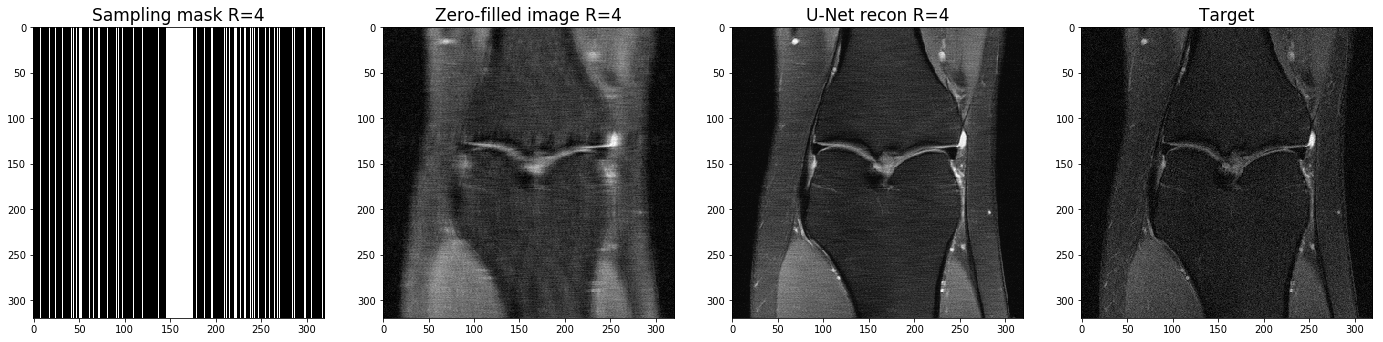

In [67]:
plt.figure(figsize=(24, 18))

plt.subplot(1, 4, 1)
ones = np.ones((mask.shape[0], mask.shape[0]))
mask_to_show = mask * ones
plt.imshow(mask_to_show, cmap='gray')
plt.title('Sampling mask R=4', fontsize=17)

plt.subplot(1, 4, 2)
plt.imshow(zero_filled[0], cmap='gray')
plt.title('Zero-filled image R=4', fontsize=17)

plt.subplot(1, 4, 3)
plt.imshow(recon, cmap='gray')
plt.title('U-Net recon R=4', fontsize=17)

plt.subplot(1, 4, 4)
plt.imshow(target, cmap='gray')
plt.title('Target', fontsize=17)
plt.show()

As in the first demo, we define some utility functions that will be used later. Some of them are taken from the first demo and should already be familiar to you.

In [51]:
def to_two_channel_complex(data: torch.Tensor) -> torch.Tensor:
    """ Change data representation from one channel complex-valued to two channers real valued """
    real = data.real
    imag = data.imag
    result = torch.empty((*data.shape, 2), dtype=torch.float32)
    result[..., 0] = real
    result[..., 1] = imag
    return result


def complex_abs(data: torch.Tensor, keepdim: bool = False) -> torch.Tensor:
    """ Convert complex image to a magnitude image (projection from complex to a real plane) """
    assert data.size(-1) == 2
    return (data ** 2).sum(dim=-1, keepdim=keepdim).sqrt()


def image_to_kspace(image: torch.Tensor) -> torch.Tensor:
    """ Convert image to the corresponding k-space using Fourier transforms """
    image_shifted = torch.fft.fftshift(image)
    kspace_shifted = torch.fft.fft2(image_shifted)
    kspace = torch.fft.ifftshift(kspace_shifted)
    return kspace


def single_coil_kspace_to_image(kspace: torch.Tensor) -> torch.Tensor:
    """ Convert k-space to the corresponding image using Fourier transforms """
    kspace_shifted = torch.fft.ifftshift(kspace)
    image_shifted = torch.fft.ifft2(kspace_shifted)
    image = torch.fft.fftshift(image_shifted).real
    return image

Now, let us implement all steps of the data consistency operation:

### Step 1: compute reverted sampling mask

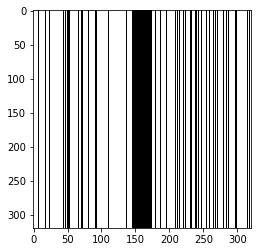

In [42]:
reverted_mask_to_show = (mask_to_show - 1) * -1 
plt.imshow(reverted_mask_to_show, cmap='gray')
plt.show()

### Step 2: prepare recon k-space

Note that the output of the U-Net reconstruction model contains vertical lines, which are leftovers from the initial undersampling. These lines indicate imperfections of obtained reconstruction.

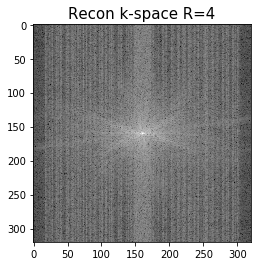

In [43]:
# As before we: 
#     1) go to k-space using Fourier transforms
#     2) convent complex-valued matrix into two channel real-valued tensor
#     3) convert complex to magnitude
recon_kspace = complex_abs(to_two_channel_complex(image_to_kspace(torch.from_numpy(recon))))

plt.imshow(torch.log(recon_kspace), cmap='gray')
plt.title('Recon k-space R=4', fontsize=15)
plt.show()

### Step 3: compute the unnecessary correction in k-space

Get this by pixel-wise multiplication with the reverted mask. 

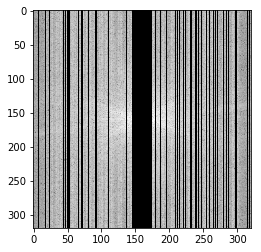

In [68]:
offset = 48
recon_kspace_consistent = reverted_mask_to_show * recon_kspace.numpy()

plt.imshow(np.log(recon_kspace_consistent + 1e-8), cmap='gray')
plt.show()

Now we can apply the resulting data consistency term in two different ways:
1. Subtract it from the recon k-space to explicitly remove corrections
2. Provide the data consistency as an additional input to the next reconstruction block to help the model compensate for it (soft data consistency)